# Attention and Transformers

The original *Attention Is All You Need* paper is [available here](https://arxiv.org/pdf/1706.03762.pdf).

The overall architecture of the **Transformer** model is defined here from the paper:
![transformers](images/transformers.png)

## Define Configurations

In [125]:
VOCAB_SIZE = 20000

In [126]:
from keras.layers import Input, Dense, LSTM, Flatten, concatenate, Activation, RepeatVector, Permute
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
#from keras_self_attention import SeqSelfAttention
import numpy as np 
import spacy
nlp = spacy.load('en_core_web_sm')

## Load in Amazon Reviews Dataset

In [127]:
from random import randint
from numpy import array, argmax, asarray, zeros
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding

In [128]:
import numpy as np
NUM_SAMPLES = 10000

good_reviews = open("good_amazon_toy_reviews.txt").readlines()
bad_reviews = open("poor_amazon_toy_reviews.txt").readlines()

sampled_good_reviews = good_reviews[:NUM_SAMPLES]
sampled_bad_reviews = bad_reviews[:NUM_SAMPLES]

docs = sampled_good_reviews + sampled_bad_reviews
labels = np.concatenate([np.ones(NUM_SAMPLES), np.zeros(NUM_SAMPLES)])

## Remove Stopwords

In [129]:
stopwords_removed_docs = list(
    map(lambda doc: " ".join([token.text for token in nlp(doc) if not token.is_stop]), docs))

## Tokenize Text

In [130]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(stopwords_removed_docs)

## Integer Encode Documents

In [167]:
from typing import List
def get_max_token_length_per_doc(docs: List[List[str]])-> int:
    return max(list(map(lambda x: len(x.split()), docs)))

# get the max length in terms of token length
max_length = get_max_token_length_per_doc(docs)


def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

from keras.preprocessing.sequence import pad_sequences
MAX_SEQUENCE_LENGTH = 300
# integer encode the documents
encoded_docs = integer_encode_documents(stopwords_removed_docs, tokenizer)
# this is a list of lists, the numbers represent the index position of that word.
# for instance, 33 means the 33rd word in the vocabulary
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

## Load in GloVe Vectors

In [132]:
def load_glove_vectors():
    embeddings_index = {}
    with open('glove.6B.100d.txt') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index


embeddings_index = load_glove_vectors()

Loaded 400000 word vectors.


## Load in Embeddings Matrix

In [133]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

In [134]:
import keras
from keras_self_attention import SeqSelfAttention


model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=VOCAB_SIZE,
                                 output_dim=100,
                                 mask_zero=True))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=32,
                                                       return_sequences=True)))
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(keras.layers.Dense(units=5))
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 100)         2000000   
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 64)          34048     
_________________________________________________________________
seq_self_attention_8 (SeqSel (None, None, 64)          4161      
_________________________________________________________________
dense_26 (Dense)             (None, None, 5)           325       
Total params: 2,038,534
Trainable params: 2,038,534
Non-trainable params: 0
_________________________________________________________________


In [135]:
DATA_POINTS = 10
DIMENSIONS = 240
SEQUENCE_LENGTH = 4

## Define an LSTM Model

In [145]:
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers import Flatten, Masking

def make_lstm_classification_model(plot=False):
    model = keras.models.Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=64, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(16))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

## Inside One LSTM Cell
![LSTM](images/lstm_architecture.jpg)

In [146]:
model = make_lstm_classification_model()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 300, 100)          2000000   
_________________________________________________________________
masking_6 (Masking)          (None, 300, 100)          0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_30 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 17        
Total params: 2,043,297
Trainable params: 43,297
Non-trainable params: 2,000,000
_________________________________________________________________


## Split Into Train/Test

In [138]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.2)

In [147]:
# fit the model
history = model.fit(padded_docs, labels, validation_split = 0.1, epochs=10, verbose=1)

Train on 18000 samples, validate on 2000 samples
Epoch 1/10
18000/18000 [==============================] - 96s 5ms/step - loss: 0.3159 - accuracy: 0.8662 - val_loss: 0.3343 - val_accuracy: 0.8630
Epoch 2/10
18000/18000 [==============================] - 108s 6ms/step - loss: 0.2313 - accuracy: 0.9097 - val_loss: 0.2924 - val_accuracy: 0.8870
Epoch 3/10
18000/18000 [==============================] - 106s 6ms/step - loss: 0.2010 - accuracy: 0.9199 - val_loss: 0.1760 - val_accuracy: 0.9280
Epoch 4/10
18000/18000 [==============================] - 107s 6ms/step - loss: 0.1815 - accuracy: 0.9304 - val_loss: 0.1846 - val_accuracy: 0.9250
Epoch 5/10
18000/18000 [==============================] - 118s 7ms/step - loss: 0.1632 - accuracy: 0.9368 - val_loss: 0.2473 - val_accuracy: 0.8975
Epoch 6/10
18000/18000 [==============================] - 116s 6ms/step - loss: 0.1455 - accuracy: 0.9454 - val_loss: 0.1795 - val_accuracy: 0.9290
Epoch 7/10
18000/18000 [==============================] - 113s 6

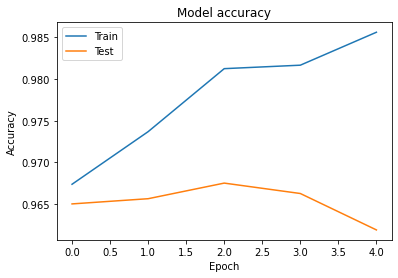

In [152]:
import matplotlib.pyplot as plt # From https://keras.io/visualization/


def plot_performance(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

plot_performance(history)

# Ways to Improve Performance

* **feature engineer** the text by grouping collocated tokens, removing stopwords, etc.

* **use K-Folds cross-validation** to "use" more of the dataset in the training/validation/testing process.

* **train your own custom domain-specific embeddings** (instead of using generic pre-trained ones)

* **tune hyperparameters** - neural network architecture, activation functions, etc. 

* **enrich the data** using augmented datasets as features

## Self Attention Model

In [195]:
def make_self_attention_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(input_dim=VOCAB_SIZE,
                                     output_dim=100,
                                     mask_zero=True))
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=300,
                                                           return_sequences=True)))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(keras.layers.Dense(units=1))
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )
    model.summary()
    return model

### Notes:

Each LSTM has a hidden state and memory. You can ask `keras` to return the vectors that represent these sequences by using:

#### Difference Between `return_sequences` and `return_states`

```python
LSTM(HIDDEN_STATE_DIMENSIONS, return_sequences=True)
```

If you had a `SEQUENCE_LENGTH` of **20**, and a `HIDDEN_STATE_DIMENSIONS` of **64**, then you'll produce a matrix of shape `64 x 20` as your `return_sequence`.

On the other hand, `return_states` will return both the memory cells (`c`) as well as the hidden state `h`:

```
lstm, state_h, state_c = LSTM(..., return_state=True)
```

Here, `lstm` will be your LSTM model, `state_h` is your hidden state, and `state_c` is your cell memory state. 

Example from [Keras Returning Hidden State in RNNs](http://digital-thinking.de/keras-returning-hidden-state-in-rnns/):
```
inputs1 = Input(shape=(5, 1))
lstm1, state_h, state_c = LSTM(1, return_state=True, return_sequences=True)(inputs1)
model = Model(inputs=inputs1, outputs=[lstm1, state_h, state_c])
data = array([0.1, 0.2, 0.3, 0.4, 0.5]).reshape((1,5,1))
print(model.predict(data))
```
The output of this is
```
[array([[[0.00734747],
        [0.02000349],
        [0.03651035],
        [0.05576567],
        [0.07689518]]], dtype=float32), array([[0.07689518]], dtype=float32), array([[0.15496857]], dtype=float32)]
```

## Model High-Level Architecture
![architecture](images/lstm_arch.png)

In [197]:
attention_model = make_self_attention_model()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, None, 100)         2000000   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, None, 600)         962400    
_________________________________________________________________
seq_self_attention_15 (SeqSe (None, None, 600)         38465     
_________________________________________________________________
dense_37 (Dense)             (None, None, 1)           601       
Total params: 3,001,466
Trainable params: 3,001,466
Non-trainable params: 0
_________________________________________________________________


In [198]:
history = model.fit(padded_docs, labels,validation_split = 0.1, epochs=5, verbose=1)

Train on 18000 samples, validate on 2000 samples
Epoch 1/5
18000/18000 [==============================] - 106s 6ms/step - loss: 0.0362 - accuracy: 0.9875 - val_loss: 0.2381 - val_accuracy: 0.9335
Epoch 2/5
18000/18000 [==============================] - 116s 6ms/step - loss: 0.0347 - accuracy: 0.9876 - val_loss: 0.1174 - val_accuracy: 0.9625
Epoch 3/5
18000/18000 [==============================] - 113s 6ms/step - loss: 0.0308 - accuracy: 0.9892 - val_loss: 0.1869 - val_accuracy: 0.9380
Epoch 4/5
18000/18000 [==============================] - 109s 6ms/step - loss: 0.0338 - accuracy: 0.9879 - val_loss: 0.1762 - val_accuracy: 0.9470
Epoch 5/5
18000/18000 [==============================] - 116s 6ms/step - loss: 0.0337 - accuracy: 0.9878 - val_loss: 0.1657 - val_accuracy: 0.9455


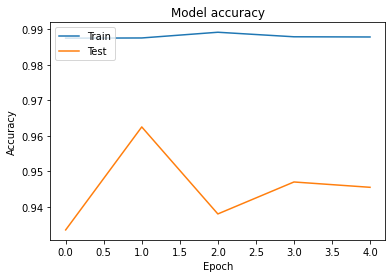

In [199]:
plot_performance(history)

In [208]:
model.layers

In [210]:
model2 = make_self_attention_model()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, None, 100)         2000000   
_________________________________________________________________
bidirectional_16 (Bidirectio (None, None, 600)         962400    
_________________________________________________________________
seq_self_attention_16 (SeqSe (None, None, 600)         38465     
_________________________________________________________________
dense_38 (Dense)             (None, None, 1)           601       
Total params: 3,001,466
Trainable params: 3,001,466
Non-trainable params: 0
_________________________________________________________________


In [223]:
weights = model.get_weights()
print(f"The sequence length is {MAX_SEQUENCE_LENGTH}.")
print(f"The input is of shape {X_train.shape}.")
print(f"The vocabulary size is {VOCAB_SIZE}.")
print(f"The word embedding dimensions size is 100.")
print(f"The hidden state dimension size is {MAX_SEQUENCE_LENGTH}.")

weight_purposes = ["word_embeddings", "data_gate_weights", "hidden_state_gate_weights",
                  "attention "]

for weights in model2.get_weights():
    print(np.array(weights).shape)

The sequence length is 300.
The input is of shape (16000, 300).
The vocabulary size is 20000.
The word embedding dimensions size is 100.
The hidden state dimension size is 300.
(20000, 100)
(100, 1200)
(300, 1200)
(1200,)
(100, 1200)
(300, 1200)
(1200,)
(600, 32)
(600, 32)
(32,)
(32, 1)
(1,)
(600, 1)
(1,)


# BERT (Bi-Directional Encoder Representations of Transformers)

## High Level Architecture

![bert](images/bert_architecture.png)

![comparison](images/bert.webp)